In [1]:
import os
import torch
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from geopy.distance import geodesic
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments, BertTokenizerFast, PreTrainedTokenizerFast, EncoderDecoderModel
from scipy.sparse import csr_matrix

In [2]:
data_path = '../Data'

In [3]:
airbnb_data = pd.read_csv(os.path.join(data_path, 'Tokyo_Airbnb', 'airbnb_data_add_latlng.csv'))
oshima_data = pd.read_csv(os.path.join(data_path, 'Oshima', 'oshima_data_translated.csv'))
open_data = pd.read_csv(os.path.join(data_path, 'OpenData', 'open_data_translated.csv'))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

----

In [5]:
open_data.columns = ['Unnamed', 'method', 'state', 'town', 'date', 'time', 'full name', 'latitude', 'longitude', 'translated']

### 일본어 -> 한국어 번역

In [6]:
# mapper = {
#     '部品ねらい':'부품 목표',
#     'ひったくり':'끈적끈적',
#     'オートバイ':'오토바이 절도',
#     '車上ねらい':'차상 목표',
#     '自動販売機ねらい':'자판기 목표',
#     '自動車盗':'차량절도',
#     '自転車盗':'자전거 도둑
# }

In [7]:
# def translate(text_src):
#     embeddings = src_tokenizer(text_src, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
#     embeddings = {k: v for k, v in embeddings.items()}
#     output = model.generate(**embeddings)[0, 1:-1]
#     text_trg = trg_tokenizer.decode(output.cpu())
#     return text_trg

In [8]:
# encoder_model_name = "cl-tohoku/bert-base-japanese-v2"
# decoder_model_name = "skt/kogpt2-base-v2"

# src_tokenizer = BertTokenizerFast.from_pretrained(encoder_model_name)
# trg_tokenizer = PreTrainedTokenizerFast.from_pretrained(decoder_model_name)
# model = EncoderDecoderModel.from_pretrained("figuringoutmine/translator-for-travel-jp-to-kr").to(device)

In [9]:
# translated = list()
# with torch.no_grad():
#     for info in tqdm(oshima_data['info'].values):
#         encoded = src_tokenizer(info, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
#         encoded = {k:v.to(device) for k, v in encoded.items()}
#         output = model.generate(**encoded)[0, 1:-1]
#         translated.append(trg_tokenizer.decode(output.cpu()))

In [10]:
# oshima_data['translated'] = translated

In [11]:
# oshima_data.to_csv(os.path.join(data_path, 'oshima_data_translated.csv'), index=False)

In [12]:
# translated = list()
# with torch.no_grad():
#     for method in tqdm(open_data['method'].values):
#         encoded = src_tokenizer(method, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
#         encoded = {k:v.to(device) for k, v in encoded.items()}
#         output = model.generate(**encoded)[0, 1:-1]
#         translated.append(trg_tokenizer.decode(output.cpu()))

In [13]:
# open_data['translated'] = translated

In [14]:
# open_data.to_csv(os.path.join(data_path, 'open_data_translated.csv'), index=False)

### Bert Embedding Base Clustering

In [15]:
from soyclustering import SphericalKMeans

In [16]:
model = AutoModel.from_pretrained('cl-tohoku/bert-base-japanese')
tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')

In [17]:
embeddings = list()

In [18]:
# oshima
with torch.no_grad():
    for info in tqdm(oshima_data['info'].values):
        encoded = tokenizer(info, return_tensors='pt')
        output = model(**encoded)
        embedding = output.pooler_output[0].detach().cpu().numpy().tolist()
        embeddings.append(embedding)

100%|███████████████████████████████████████████████████████████████████████████████| 4833/4833 [01:34<00:00, 51.31it/s]


In [19]:
# # opendata
# with torch.no_grad():
#     for info in tqdm(open_data['info'].values):
#         encoded = tokenizer(info, return_tensors='pt')
#         output = model(**encoded)
#         embedding = output.pooler_output[0].detach().cpu().numpy().tolist()
#         embeddings.append(embedding)

In [20]:
embeddings = csr_matrix(embeddings)

In [21]:
spherical_kmeans = SphericalKMeans(
    n_clusters=7,    #  7개의 군집으로 군집화
    max_iter=100,    # 최대 Iteration 수
    verbose=1,
    init='similar_cut'
)

In [22]:
labels = spherical_kmeans.fit_predict(embeddings)

initialization_time=0.001360 sec, sparsity=0.999
n_iter=1, changed=4181, inertia=793.826, iter_time=1.043 sec, sparsity=1.0
n_iter=2, changed=712, inertia=486.143, iter_time=1.010 sec, sparsity=1.0
n_iter=3, changed=350, inertia=462.051, iter_time=1.030 sec, sparsity=1.0
n_iter=4, changed=225, inertia=456.034, iter_time=1.011 sec, sparsity=1.0
n_iter=5, changed=130, inertia=454.284, iter_time=1.017 sec, sparsity=1.0
n_iter=6, changed=88, inertia=453.503, iter_time=1.009 sec, sparsity=1.0
n_iter=7, changed=60, inertia=453.215, iter_time=1.007 sec, sparsity=1.0
n_iter=8, changed=26, inertia=453.115, iter_time=0.999 sec, sparsity=1.0
n_iter=9, changed=25, inertia=453.109, iter_time=0.995 sec, sparsity=1.0
n_iter=10, changed=15, inertia=453.094, iter_time=0.995 sec, sparsity=1.0
n_iter=11, changed=24, inertia=453.085, iter_time=1.024 sec, sparsity=1.0
n_iter=12, changed=16, inertia=453.081, iter_time=1.017 sec, sparsity=1.0
n_iter=13, changed=13, inertia=453.084, iter_time=0.997 sec, spars

In [23]:
oshima_kmeans = oshima_data.copy()
oshima_kmeans['labels'] = labels

In [40]:
oshima_kmeans[oshima_kmeans['labels']==0].sample(10)    # 기타

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
2723,2731,中野区,東京都中野区中野三丁目2321 コーポ池田,2階 角部屋 心理的瑕疵あり 2018年6月内装一部リフォーム済み,平成30年4月22日,東京都 中野区 中野 三丁目,35.702892,139.663330,2층 가방적용적하적 있어 2018년 6월 인테리어 일부 리모델링 완료,0
775,783,葛飾区,千葉県松戸市栗山121-24. 102号室,告知事項有り,平成28年5月,千葉県 松戸市 栗山 121番地,35.756519,139.898697,공고사항 있음,0
2961,2972,東村山市,東京都東村山市本町一丁目1324,２２２号室は告知事項あり、室内全体の補修工事が行われたらしいが、どのようなことがあったのか不...,令和2年2月1日,東京都 東村山市 本町 一丁目,35.754921,139.467194,1호실은 공지사항이며 실내 전체 보수공사가 이루어졌다고 하는데 어떤 일이 있었는지 알 수,0
3241,3257,新宿区,東京都新宿区南元町4-57 アクサスレジデンス外苑 1階,告知事項あり,2020年頃,東京都 新宿区 南元町 4番地,35.681904,139.723328,공고사항,0
702,705,狛江市,東京都狛江市岩戸北三丁目196（フラットえびす）,警察が来て、ブルーシートに遺体を乗せてワゴン車で運び出した。事件性の可否は不明。,2016２月か３月頃,東京都 狛江市 岩戸 北三丁目,35.633904,139.583282,경찰이 와서 블루 시트에 시신을 태우고 와곡 차로 옮겼다.사건 가능성은 불투명.,0
2058,2066,八王子市,東京都八王子市南大沢二丁目206-21,グランツ フリーデ 303号室 アパマンショップ橋本店より\r\n告知事項あり,不明,東京都 八王子市 南大沢 二丁目 206番地,35.612087,139.384445,그란츠 프리데 303호실 아파마시 숍하모토점에서 공지,0
2527,2535,新宿区,東京都新宿区歌舞伎町二丁目396,1F 首吊り,2010年頃,東京都 新宿区 歌舞伎町 二丁目,35.696556,139.703827,1F 목살,0
2196,2204,武蔵野市,東京都武蔵野市桜堤一丁目6-31 ハイツエイト2,2階 角部屋 南向き1K（洋室7帖、K3帖） 専有面積23㎡\r\n告知事項あり\r\n20...,令和4年6月1日,東京都 武蔵野市 桜堤 一丁目 6番 31号,35.709641,139.537628,"2층 각방 남향 1K, 1룸 7첩, K3쪽(전유",0
2943,2954,青梅市,東京都青梅市東青梅三丁目85,告知事項あり。業者は全オーナーが病死と伝えてきたが、正確には前々オーナーが自殺、全オーナーが...,2018年時点での情報,東京都 青梅市 東青梅 三丁目,35.789589,139.277374,"공지사항 있음. 업체는 전 주인이 사망이라고 전했지만, 정확하게는 전 주인이 자살하고",0
1021,1029,千代田区,東京都千代田区飯田橋四丁目5-14 飯田橋サンポーロハイツ,10階 分譲賃貸 南西向き1LDK（LDK10帖、洋室6帖） 専有面積37.39㎡ 賃料12...,令和4年9月24日,東京都 千代田区 飯田橋 四丁目 5番 14号,35.700638,139.747498,"10층 분양 임대남향NDWLK 1L(DLK10권,",0


In [44]:
oshima_kmeans[oshima_kmeans['labels']==1].sample(10)    # 사체 발견

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
4425,4441,大田区,神奈川県川崎市川崎区堀之内町13−41,105号室にて腐乱死体発見,平成30年7月9日,神奈川県 川崎市 川崎区 堀之内町 13番,35.534088,139.706467,105호실에서 부패사체 발견,1
318,318,新宿区,東京都新宿区新宿五丁目189 シンエイ商会,倉庫2階 腐乱死体発見,平成22年5月31日,東京都 新宿区 新宿 五丁目,35.693169,139.707870,창고 2층 부패사체 발견,1
38,38,新宿区,東京都新宿区歌舞伎町二丁目9−１５,401号、病死,26年5月,東京都 新宿区 歌舞伎町 二丁目 9番 15号,35.695618,139.705643,"401호, 병살",1
3802,3818,台東区,東京都台東区浅草橋四丁目14-4,リブラン今井303号\r\n孤高死,2017年6月7日,東京都 台東区 浅草橋 四丁目 14番 4号,35.698448,139.780853,립란 이마이303호 고고사,1
1605,1613,目黒区,東京都品川区小山六丁目1第5開成荘,近所の人の話\r\n灯油をかぶって焼身自殺があったそうです。,15年位前,東京都 品川区 小山 六丁目 1番,35.614887,139.698029,이웃 사람의 화투불을 피워서 불산 자살이 있었다고 합니다.,1
4196,4212,世田谷区,東京都世田谷区南烏山四丁目14-22,201号室で亡くなった方がいたという告知事項あり。,2022年6月,東京都 世田谷区 南烏山 四丁目 14番 22号,35.670574,139.600952,201호실에서 돌아가신 분이 있었다는 공지사항 있습니다.,1
3404,3420,足立区,東京都足立区花畑八丁目五丁目21-410,一人暮らしの年配の男性がトイレで首吊り自殺,2000年～2010年の間,東京都 足立区 花畑 八丁目 5番,35.813137,139.821381,혼자 사는 나이든 남자가 화장실에서 숨지고 자살한,1
4608,4624,渋谷区,東京都港区白金五丁目10-8,一人暮らしの女性の腐乱死体が発見,2020年3月,東京都 港区 白金 五丁目 10番,35.644810,139.724747,혼자 사는 여성의 부패사체가 발견,1
3407,3423,足立区,東京都足立区花畑八丁目8番地２１号棟,飛び降り自殺数件,2001年 9月 他,東京都 足立区 花畑 八丁目 8番,35.811661,139.823578,비명 자살 몇 건,1
649,650,国分寺市,東京都国分寺市戸倉一丁目825 PlaceK,5階 角部屋\r\n告知事項有り,令和4年10月6日,東京都 国分寺市 戸倉 一丁目,35.712097,139.461227,5층 각방고시사항 있음,1


In [36]:
oshima_kmeans[oshima_kmeans['labels']==2].sample(10)    # 화재로 인한 사망

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
4638,4654,渋谷区,東京都渋谷区笹塚一丁目23-7コーポ万栄206,火災による死亡,令和4年10月12日,東京都 渋谷区 笹塚 一丁目 23番 7号,35.673145,139.667847,화재로 인한 사망,2
4572,4588,中野区,東京都練馬区豊玉南三丁目4-1豊玉南住宅1401,火災による死亡,平成19年11月28日,東京都 練馬区 豊玉 南三丁目 4番 1号,35.727222,139.653763,화재로 인한 사망,2
3895,3911,小平市,東京都小平市上水本町五丁目12,火災による死亡,平成23年2月19日,東京都 小平市 上水本町 五丁目 12番,35.710178,139.478500,화재로 인한 사망,2
132,132,板橋区,東京都荒川区荒川三丁目30-4,火災による死亡,平成21年12月24日,東京都 荒川区 荒川 三丁目 30番 4号,35.734417,139.781876,화재로 인한 사망,2
872,880,葛飾区,東京都足立区東綾瀬二丁目3-22シルバーピア東綾瀬6階,熱中症による死亡,平成25年7月14日,東京都 足立区 東綾瀬 二丁目 3番 22号,35.767567,139.829987,열사병에 의한 사망,2
3984,4000,東村山市,埼玉県所沢市下安松379-1森田コーポ305,火災による死亡,平成29年6月30日,埼玉県 所沢市 大字下安松 379番地,35.782562,139.498962,화재로 인한 사망,2
1810,1818,北区,東京都北区豊島五丁目4-2 UR豊島五丁目団地2号棟223,火災による死亡,平成28年7月20日,東京都 北区 豊島 五丁目 4番 2号,35.764240,139.752029,화재로 인한 사망,2
2203,2211,武蔵村山市,東京都武蔵村山市緑が丘一丁目都営村山アパート1126号棟203,火災による死亡,平成29年5月3日,東京都 武蔵村山市 緑が丘,35.742924,139.407913,화재로 인한 사망,2
2110,2118,三鷹市,東京都世田谷区北烏山七丁目28-11,火災による死亡,平成18年7月26日,東京都 世田谷区 北烏山 七丁目 28番 11号,35.681889,139.588333,화재로 인한 사망,2
1859,1867,北区,東京都豊島区駒込六丁目5-1アルス駒込405,火災による死亡,平成19年2月2日,東京都 豊島区 駒込 六丁目 5番 1号,35.737934,139.740631,화재로 인한 사망,2


In [37]:
oshima_kmeans[oshima_kmeans['labels']==3].sample(10)    # 투신자살

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
316,316,新宿区,東京都新宿区歌舞伎町二丁目185プラーズタワー東新宿↓,飛び降り自殺,平成25年3月9日,東京都 新宿区 歌舞伎町 二丁目,35.696556,139.703827,뛰어내리 자살,3
2890,2899,目黒区,東京都目黒区上目黒二丁目1720,心理的瑕疵,2012,東京都 目黒区 上目黒 二丁目,35.641190,139.696899,심리적 하자,3
663,666,青梅市,東京都青梅市東青梅二丁目1913 ホーユウコンフォルト東青梅 3階,心理的瑕疵有,時期不明,東京都 青梅市 東青梅 二丁目,35.791119,139.272705,심리적 하자유무,3
104,104,北区,大阪府堺市北区長曽根町545-1,飛び降り自殺,平成23年5月5日,大阪府 堺市 北区 長曽根町 545番地,34.563553,135.514175,뛰어내리 자살,3
478,478,中央区,兵庫県神戸市中央区雲井通三丁目6,自殺,2001年3月以降,兵庫県 神戸市 中央区 雲井通 三丁目 6番,34.696602,135.199570,자살,3
1022,1030,千代田区,東京都千代田区飯田橋四丁目4-13,自殺,2017年初旬,東京都 千代田区 飯田橋 四丁目 4番 13号,35.700062,139.747330,자살,3
2226,2234,青梅市,東京都羽村市小作台五丁目24-1,孤高死,2017~2018,東京都 羽村市 小作台 五丁目 24番,35.773674,139.304138,고고사,3
4730,4746,調布市,東京都調布市仙川町二丁目7-22マンション仙川アゼリア9階共用通路↓,飛び降り自殺,平成25年1月30日,東京都 調布市 仙川町 二丁目 7番,35.662502,139.581192,뛰어내리 자살,3
2588,2596,新宿区,東京都新宿区歌舞伎町二丁目215,飛び降り自殺,平成30年10月12日,東京都 新宿区 歌舞伎町 二丁目,35.696556,139.703827,뛰어내리 자살,3
987,995,千代田区,東京都港区新橋一丁目18-6,飛び降り自殺？,平成30年1月5日,東京都 港区 新橋 一丁目 18番,35.668629,139.755844,뛰어내리는 자살!,3


In [42]:
oshima_kmeans[oshima_kmeans['labels']==4].sample(10)    # 고독사

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
1814,1822,北区,東京都北区豊島五丁目5-8号棟５１２,特別募集,不明,東京都 北区 豊島 五丁目 5番 8号,35.763367,139.753998,특별모집,4
1289,1297,荒川区,東京都荒川区東尾久一丁目5-22,老人男性の孤高死,2013年夏頃,東京都 荒川区 東尾久 一丁目 5番 22号,35.738865,139.772888,노인성 고고령사,4
214,214,狛江市,東京都狛江市和泉本町一丁目13-16,遺体発見,平成30年1月28日,東京都 狛江市 和泉本町 一丁目 13番 16号,35.638565,139.579391,시신 발견,4
788,796,葛飾区,東京都江戸川区北小岩七丁目19-2,心理的瑕疵物件あり,平成17年9月1日,東京都 江戸川区 北小岩 七丁目 19番 2号,35.744682,139.891098,심리적 하자물건,4
1945,1953,立川市,東京都立川市幸町六丁目34-10ＵＲ立川幸町団地12号棟203号室,特別募集住宅,不明,東京都 立川市 幸町 六丁目 34番,35.727779,139.426849,특별모집주택,4
1416,1424,町田市,神奈川県大和市下鶴間806-18ブルーメゾンつきみ野201,傷害致死,平成30年8月22日,神奈川県 大和市 下鶴間 806番地,35.506287,139.463959,상해치사,4
1819,1827,北区,東京都北区豊島五丁目五丁目9-919,老人の孤高死,2012年か2013年,東京都 北区 豊島 五丁目 5番,35.766319,139.752853,노인의 고독사,4
234,234,新宿区,東京都新宿区西新宿七丁目2231,事故死,2016,東京都 新宿区 西新宿 七丁目,35.695580,139.697235,사고,4
958,966,千代田区,東京都千代田区神田佐久間町一丁目27石鍋ビル↓,転落死,令和3年7月2日,東京都 千代田区 神田佐久間町 一丁目 27番地,35.698475,139.775192,회전사,4
3470,3486,足立区,東京都葛飾区小菅四丁目五丁目13-202,腐敗臭により発見,平成27年10月27日,東京都 葛飾区 小菅 四丁目 5番,35.759567,139.824432,부패로 인해 발견,4


In [47]:
oshima_kmeans[oshima_kmeans['labels']==5].sample(10)    # 실내에서 자살(목졸라 사망)

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
3997,4013,日野市,東京都多摩市和田1261-29,午前5時半ごろ最上階11階から女性飛び降り自殺。2階の踊り場に直撃。,6、7年前,東京都 多摩市 和田 1261番地,35.645988,139.415894,오전 5시 반경 최상층 11층에서 여성 뛰어내리며 자살. 2층 무도장에,5
4148,4164,板橋区,東京都豊島区池袋二丁目32-9 カーサナカムラ101号室,リビングにて首吊り自殺,令和3年3月1日,東京都 豊島区 池袋 二丁目 32番 9号,35.734432,139.706238,거실에서 목을 졸라 자살한,5
1104,1112,狛江市,東京都狛江市猪方四丁目12-1ビューハイツ・多摩川206,首吊り自殺,平成23年10月9日,東京都 狛江市 猪方 四丁目 12番,35.623280,139.580505,목살 자살,5
2541,2549,新宿区,東京都新宿区西新宿一丁目1,首吊り自殺,令和2年1月7日,東京都 新宿区 西新宿 一丁目 1番,35.688580,139.699432,목살 자살,5
2249,2257,あきる野市,東京都福生市南田園三丁目6-12,2013年頃\r\n男性 睡眠薬を飲み\r\n首吊り自殺,2013年頃,東京都 福生市 南田園 三丁目 6番,35.730122,139.331039,2013년경 남성 수면제를 먹고 목졸라 자살,5
2551,2559,新宿区,東京都新宿区歌舞伎町二丁目1414コスモ佐藤4F,首吊り自殺,平成17年,東京都 新宿区 歌舞伎町 二丁目,35.696556,139.703827,목살 자살,5
516,516,杉並区,東京都杉並区阿佐谷南一丁目125,高層階から中庭に飛び降り自殺,2007年ごろ,東京都 杉並区 阿佐谷 南一丁目,35.701118,139.639847,고층층에서 중당으로 뛰어내리고 자살,5
2500,2508,小平市,東京都立川市泉町1156-4,薬使用後に７階位の踊り場から飛び降り自殺。\r\n１８歳位の男性,８年位前,東京都 立川市 泉町 1156番地,35.715286,139.406281,약 사용 후 1층 높이에서 뛰어내리며 자살.,5
3581,3597,墨田区,東京都墨田区菊川3-3-22パレドール芙美102,首吊り自殺,2019年,東京都 墨田区 菊川 三丁目 3番 22号,35.686905,139.807724,목살 자살,5
2205,2213,武蔵村山市,東京都武蔵村山市緑が丘2542,深夜2時頃、マンションの８階から飛び降り自殺。\r\n転落防止用の金網を貫きバリアフリー用の...,2012年頃,東京都 武蔵村山市 緑が丘 2542番地,35.738750,139.407654,심야 2시쯤 1층부터 뛰어내려 자살. 추락 방지를 위한 철망 너머로,5


In [50]:
oshima_kmeans[oshima_kmeans['labels']==6].sample(10)    # 공지사항

,Unnamed: 0,district,address,info,date,full name,latitude,longitude,translated,labels
514,514,杉並区,東京都杉並区成田東四丁目3518 メゾン中里,1階 心理的瑕疵あり,平成30年11月6日,東京都 杉並区 成田 東四丁目,35.696785,139.636108,1층 심리적 하자 있음.,6
1537,1545,西東京市,東京都小平市花小金井南町二丁目九丁目34-4,孤高死があった模様,2020年6月,東京都 小平市 花小金井南町 二丁目 9番,35.721313,139.517654,고고한 죽음이 있었던 모양입니다.,6
64,64,豊島区,東京都豊島区南池袋二丁目9-17ニッシンパレステージ池袋804,男性の変死体発見,2018年６月,東京都 豊島区 南池袋 二丁目 9番 17号,35.725307,139.714676,남성의 변사체 발견,6
1832,1840,北区,東京都北区豊島一丁目21-13 新橋ハイツ,201号室 角部屋\r\n告知事項あり,令和4年9月16日,東京都 北区 豊島 一丁目 21番 13号,35.758060,139.740738,2016호실 각 방안내사항,6
606,607,足立区,東京都足立区梅島一丁目246 シティーフラッツ,203号室\r\n告知事項有,令和4年5月24日,東京都 足立区 梅島 一丁目,35.772495,139.800705,203호실 공지사항유,6
1387,1395,町田市,東京都町田市能ヶ谷一丁目15-22 コーポ神蔵,202号室\r\n告知事項あり,令和4年5月30日,東京都 町田市 能ヶ谷 一丁目 15番,35.582630,139.481049,202호실 공지사항,6
1420,1428,町田市,東京都町田市南町田三丁目9-35 ゴールドバーデン,孤高死・203号室,令和元年7月23日,東京都 町田市 南町田 三丁目 9番,35.517132,139.466400,고고사 203호실,6
52,52,台東区,東京都台東区東上野一丁目14タイムズ東上野第27,死体発見,平成24年12月4日,東京都 台東区 東上野 一丁目 14番,35.707973,139.776810,시체 발견,6
4745,4761,調布市,東京都調布市西つつじケ丘四丁目二三丁目20-504,玄関で松田さんの遺体発見,平成20年5月15日,東京都 調布市 西つつじケ丘 四丁目 23番,35.654198,139.573532,현관에서 마쓰다 씨의 시신 발견,6
2474,2482,東村山市,東京都東村山市栄町三丁目1-28 久米川マンション 5階,告知事項あり（不動産情報より）,2020年2月現在,東京都 東村山市 栄町 三丁目 1番,35.751610,139.467377,공지사항 있습니다~ 부동산 정보부터!,6


----

### 번역된 사건내용으로 LDA 학습

In [24]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt
from konlpy.tag import Mecab

In [25]:
def compute_evaluation_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values=[]
    model_list = []
    for num_topics in range(start, limit+1, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
    return model_list, coherence_values, perplexity_values

In [31]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 20
    start = 2
    step=1

    model_list, coherence_values, perplexity_values = compute_evaluation_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = list(range(start, limit+1))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title("Coherence Scores")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.title("Perplexity Scores")
    plt.legend(("Perplexity_values"), loc='best')
    plt.show()

In [16]:
mecab = Mecab()

In [21]:
tokens = list()
for trans in oshima_data.translated:
    tokens.append(mecab.nouns(trans))

In [27]:
id2word = corpora.Dictionary(tokens)
corpus = [id2word.doc2bow(crime_tokens) for crime_tokens in tokens]

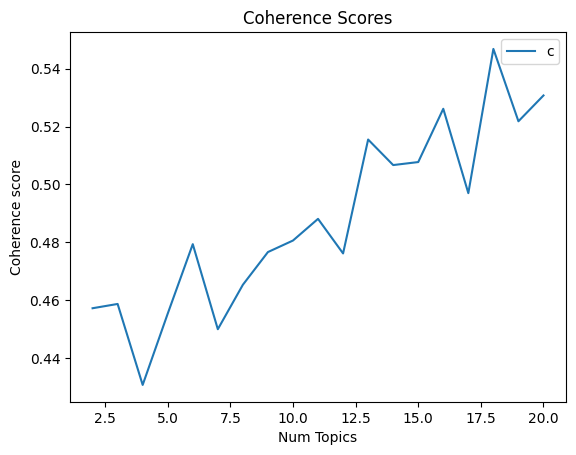

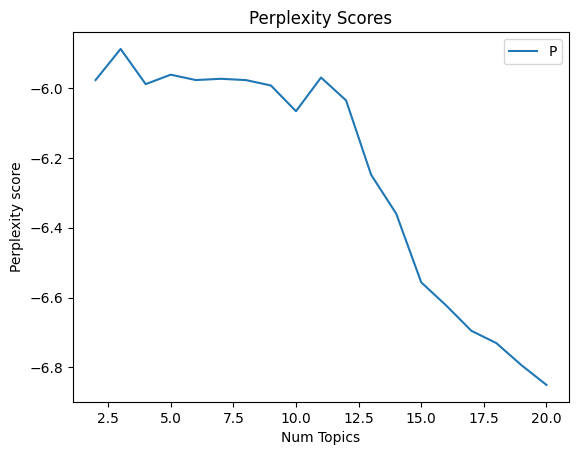

In [32]:
find_optimal_number_of_topics(dictionary=id2word, corpus=corpus, processed_data=tokens)

In [33]:
num_topics = 6

In [34]:
lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=500, passes=10)

In [35]:
topics = lda.print_topics(num_words=20)
topic_keywords = list()
for topic in topics:
    topic_num, keywords = topic
    topic_row = [topic_num+1]
    for keyword in keywords.split('+'):
        score, kw = keyword.split('*')
        kw = kw.replace('"', '').strip()
        topic_row.append(kw)
    topic_keywords.append(topic_row)
    print(topic)

(0, '0.321*"자살" + 0.059*"고사" + 0.034*"층" + 0.022*"사체" + 0.021*"회전" + 0.019*"사고" + 0.017*"남자" + 0.017*"부패" + 0.012*"목" + 0.009*"비옷" + 0.008*"아파트" + 0.008*"사망자" + 0.007*"주민" + 0.007*"中" + 0.006*"주차장" + 0.006*"무리" + 0.005*"백골" + 0.005*"안" + 0.005*"중심" + 0.005*"당시"')
(1, '0.126*"사항" + 0.122*"공지" + 0.056*"부동산" + 0.052*"정보" + 0.048*"호실" + 0.025*"층" + 0.024*"년" + 0.015*"방" + 0.014*"심리" + 0.013*"월" + 0.013*"기재" + 0.010*"면적" + 0.009*"사이트" + 0.009*"번호" + 0.008*"델" + 0.008*"리모" + 0.008*"전용" + 0.007*"중" + 0.007*"임대" + 0.006*"원룸"')
(2, '0.230*"발견" + 0.135*"시체" + 0.030*"시신" + 0.025*"병살" + 0.025*"호" + 0.017*"모집" + 0.017*"층" + 0.013*"주택" + 0.012*"특별" + 0.012*"남성" + 0.012*"고비" + 0.010*"후" + 0.009*"부패" + 0.009*"호동" + 0.007*"만" + 0.007*"입주자" + 0.007*"유채" + 0.006*"부지" + 0.005*"욕실" + 0.005*"계단"')
(3, '0.178*"사망" + 0.110*"화재" + 0.084*"심리" + 0.038*"목살" + 0.027*"물건" + 0.026*"노인" + 0.020*"고독사" + 0.018*"후" + 0.016*"유무" + 0.014*"사건" + 0.010*"남성" + 0.010*"여자" + 0.010*"층" + 0.008*"번호" + 0.007*"독거" + 0.007*"여성" + 0

### 각 숙소별 반경 nKm 내 사고 발생 건수

In [ ]:
def get_distances(locs_1, locs_2):
    n_rows_1 = locs_1.shape[0]
    n_rows_2 = locs_2.shape[0]
    dists = np.empty((n_rows_1, n_rows_2))
    # The loops here are inefficient
    for i in range(n_rows_1):
        for j in range(n_rows_2):
            dists[i, j] = geodesic(locs_1[i], locs_2[j]).km
    return dists

In [ ]:
oshima_with_location = pd.read_csv(os.path.join(data_path, 'oshima_data_sample.csv'))

In [ ]:
crime_locations = oshima_with_location[['latitude', 'longitude']].values

In [ ]:
# 에어비앤비 데이터 사용하여 사고 건수 계산
airbnb_locations = airbnb_data[['latitude', 'longitude']].values

In [ ]:
distance_matrix = get_distances(airbnb_locations, crime_locations)

In [ ]:
n_km = 3    # 3km 이내 범죄 발생 건수

In [ ]:
n_crimes = np.sum((distance_matrix < n_km), axis=1)

In [ ]:
airbnb_data['n_crimes'] = n_crimes

In [ ]:
airbnb_data